In [1]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as multi
from tqdm.auto import tqdm
from ast import literal_eval
from pymatgen.ext.matproj import MPRester
from pymatgen.core.composition import Composition

from htvs_module.htvs_mods import e_above_hull_calculator, get_PD_entries_new

In [2]:
df = pd.read_csv('./data/01_2_substitution_final.csv')
df

,sub_comp,mpid,reduced_formula
0,"['Li', 'S', 'Li', 1.0, 1.0, 2.0]",mp-1001784,Li3S
1,"['Li', 'S', 'B', 1.0, 1.0, 2.0]",mp-1001784,LiB2S
2,"['Li', 'S', 'C', 1.0, 1.0, 2.0]",mp-1001784,LiC2S
3,"['Li', 'S', 'N', 1.0, 1.0, 2.0]",mp-1001784,LiSN2
4,"['Li', 'S', 'O', 1.0, 1.0, 2.0]",mp-1001784,LiSO2
...,...,...,...
555,"['Li', 'Te', 'S', 1.0, 1.0, 1.0]",mp-10687,LiTeS
556,"['Li', 'I', 'S', 1.0, 1.0, 1.0]",mp-10687,LiSI
557,"['Li', 'Ba', 'S', 1.0, 1.0, 1.0]",mp-10687,BaLiS
558,"['Li', 'Hg', 'S', 1.0, 1.0, 1.0]",mp-10687,LiHgS


# Unique formula dataset

In [3]:
unique_formula = list(set(df['reduced_formula']))

In [4]:
unique_formula_df = pd.DataFrame(columns=['pretty_formula','composition'])
unique_formula_df['pretty_formula'] = unique_formula
unique_formula_df['composition'] = [Composition(i).formula.replace(' ','') for i in unique_formula]
unique_formula_df

,pretty_formula,composition
0,LiCaS2,Li1Ca1S2
1,LiC2S3,Li1C2S3
2,LiB2S,Li1B2S1
3,LiBS2,Li1B1S2
4,LiMg3S2,Li1Mg3S2
...,...,...
210,Li3MgS2,Li3Mg1S2
211,Li3SiS2,Li3Si1S2
212,Li3AsS2,Li3As1S2
213,LiB3S2,Li1B3S2


In [5]:
unique_formula_df.to_csv('./data/02_1_unique_compositions.csv',index=False)
unique_formula_df = pd.read_csv('./data/02_1_unique_compositions.csv')

## Unique chemsys list

In [6]:
df = unique_formula_df[:]

In [7]:
elements = []
df['elements']=pd.Series()
for i in tqdm(range(len(df))):
    ele_list = Composition(df['composition'][i]).chemical_system.split('-')
    elements.append(ele_list)
df['elements'] = elements
df

/tmp/ipykernel_385078/3397646441.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df['elements']=pd.Series()
/tmp/ipykernel_385078/3397646441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elements']=pd.Series()


  0%|          | 0/215 [00:00<?, ?it/s]

/tmp/ipykernel_385078/3397646441.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elements'] = elements


,pretty_formula,composition,elements
0,LiCaS2,Li1Ca1S2,"[Ca, Li, S]"
1,LiC2S3,Li1C2S3,"[C, Li, S]"
2,LiB2S,Li1B2S1,"[B, Li, S]"
3,LiBS2,Li1B1S2,"[B, Li, S]"
4,LiMg3S2,Li1Mg3S2,"[Li, Mg, S]"
...,...,...,...
210,Li3MgS2,Li3Mg1S2,"[Li, Mg, S]"
211,Li3SiS2,Li3Si1S2,"[Li, S, Si]"
212,Li3AsS2,Li3As1S2,"[As, Li, S]"
213,LiB3S2,Li1B3S2,"[B, Li, S]"


In [8]:
df['elements_tuple'] = [ tuple(sorted(i)) for i in df['elements']]
df

/tmp/ipykernel_385078/878917734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['elements_tuple'] = [ tuple(sorted(i)) for i in df['elements']]


,pretty_formula,composition,elements,elements_tuple
0,LiCaS2,Li1Ca1S2,"[Ca, Li, S]","(Ca, Li, S)"
1,LiC2S3,Li1C2S3,"[C, Li, S]","(C, Li, S)"
2,LiB2S,Li1B2S1,"[B, Li, S]","(B, Li, S)"
3,LiBS2,Li1B1S2,"[B, Li, S]","(B, Li, S)"
4,LiMg3S2,Li1Mg3S2,"[Li, Mg, S]","(Li, Mg, S)"
...,...,...,...,...
210,Li3MgS2,Li3Mg1S2,"[Li, Mg, S]","(Li, Mg, S)"
211,Li3SiS2,Li3Si1S2,"[Li, S, Si]","(Li, S, Si)"
212,Li3AsS2,Li3As1S2,"[As, Li, S]","(As, Li, S)"
213,LiB3S2,Li1B3S2,"[B, Li, S]","(B, Li, S)"


In [9]:
df.to_csv('./data/02_2_substiution_final_with_elements.csv',index=False)

# Get entries from MP

In [10]:
df = pd.read_csv('./data/02_2_substiution_final_with_elements.csv')
df

,pretty_formula,composition,elements,elements_tuple
0,LiCaS2,Li1Ca1S2,"['Ca', 'Li', 'S']","('Ca', 'Li', 'S')"
1,LiC2S3,Li1C2S3,"['C', 'Li', 'S']","('C', 'Li', 'S')"
2,LiB2S,Li1B2S1,"['B', 'Li', 'S']","('B', 'Li', 'S')"
3,LiBS2,Li1B1S2,"['B', 'Li', 'S']","('B', 'Li', 'S')"
4,LiMg3S2,Li1Mg3S2,"['Li', 'Mg', 'S']","('Li', 'Mg', 'S')"
...,...,...,...,...
210,Li3MgS2,Li3Mg1S2,"['Li', 'Mg', 'S']","('Li', 'Mg', 'S')"
211,Li3SiS2,Li3Si1S2,"['Li', 'S', 'Si']","('Li', 'S', 'Si')"
212,Li3AsS2,Li3As1S2,"['As', 'Li', 'S']","('As', 'Li', 'S')"
213,LiB3S2,Li1B3S2,"['B', 'Li', 'S']","('B', 'Li', 'S')"


In [11]:
unique_chemsys = set(df['elements_tuple'])
len(unique_chemsys)

27

In [12]:
for elements in tqdm(unique_chemsys,total = len(unique_chemsys)):
    if type(elements) == str:
        elements = literal_eval(elements)
    list(elements).sort()
    chemsys_str = "".join(elements)
    entries_path = f'./data/entries_from_unique_chemsys/{chemsys_str}_all_entries_MP.pickle'
    if os.path.exists(entries_path):
        continue    
    with MPRester() as m:
        entries = m.get_entries_in_chemsys(elements) # get a list of all entries in the given chemsys(= elements list)
    with open(entries_path,'wb') as fw:
        pickle.dump(entries, fw)

  0%|          | 0/27 [00:00<?, ?it/s]

# Data processing for machine learning prediction

In [13]:
roost_df = pd.DataFrame(columns=['id','composition','target'])
roost_df['id'] = df.index
roost_df['composition'] = df['composition']
roost_df['target']=0
roost_df

,id,composition,target
0,0,Li1Ca1S2,0
1,1,Li1C2S3,0
2,2,Li1B2S1,0
3,3,Li1B1S2,0
4,4,Li1Mg3S2,0
...,...,...,...
210,210,Li3Mg1S2,0
211,211,Li3Si1S2,0
212,212,Li3As1S2,0
213,213,Li1B3S2,0


In [14]:
roost_df.to_csv('./data/02_3_unique_formula_for_roost.csv',index=False) 
# use this data as input for composition-based machine learning prediction
# Instructions for the supervised machine learning model is described in https://github.com/CompRhys/roost

# Get machine learning prediction for formation energy

In [15]:
roost_result_df = pd.read_csv('./data/02_4_form_e_roost.csv')
# results obtained from a machine learning prediction
roost_result_df

,id,composition,target,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
0,0,Li2Zn2S1,0.0,-0.503801,-0.504237,-0.464071,-0.458908,-0.706559,-0.629312,-0.551264,-0.666639,-0.494119,0.279193
1,1,Na1Li6S4,0.0,-1.407286,-1.361668,-1.396600,-1.407526,-1.364364,-1.436644,-1.408766,-1.182713,-1.282647,-1.367285
2,2,Li17Se6S5,0.0,-1.263875,-1.437683,-1.289232,-1.418790,-1.485011,-1.508207,-1.517327,-1.381046,-1.465291,-1.415749
3,3,Li1Se2S1,0.0,-0.656618,-0.715617,-0.732087,-0.802266,-0.764880,-0.742529,-0.703482,-0.707799,-0.794974,-0.553902
4,4,Li2C19S15,0.0,0.150668,0.373053,0.083842,0.178857,0.195787,0.082773,0.509351,-0.062904,0.191451,0.132817
...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,433,Li2S1N2,0.0,-0.493965,-0.455717,-0.397119,-0.644969,-0.667049,-0.553184,-0.558064,-0.595338,-0.598903,-0.523838
434,434,Li17Pb6S5,0.0,-0.690666,-0.680627,-0.732680,-0.828497,-0.844610,-0.861045,-0.773509,-0.776763,-0.694203,-0.750898
435,435,Li2Al6S1,0.0,-0.270490,-0.288765,-0.265009,-0.319046,-0.360441,-0.343734,-0.361604,-0.390876,-0.075293,-0.262123
436,436,Ba15Li2S19,0.0,-2.062937,-2.091171,-2.021337,-2.041863,-1.998769,-2.040176,-2.000903,-1.803010,-2.060987,-2.009034


In [16]:
roost_ensemble_mean = roost_result_df.iloc[:,:2].rename(columns={'target':'roost_ensemble_mean'})
roost_ensemble_mean['roost_ensemble_mean'] = [roost_result_df.iloc[i,3:].mean() for i in tqdm(range(len(roost_result_df)))]
roost_ensemble_mean

  0%|          | 0/438 [00:00<?, ?it/s]

,id,composition,roost_ensemble_mean
0,0,Li2Zn2S1,-0.469972
1,1,Na1Li6S4,-1.361550
2,2,Li17Se6S5,-1.418221
3,3,Li1Se2S1,-0.717415
4,4,Li2C19S15,0.183569
...,...,...,...
433,433,Li2S1N2,-0.548815
434,434,Li17Pb6S5,-0.763350
435,435,Li2Al6S1,-0.293738
436,436,Ba15Li2S19,-2.013019


In [17]:
roost_ensemble_mean.to_csv('./data/02_5_formation_energy_roost_mean.csv',index=False)

In [18]:
roost_ensemble_mean = pd.read_csv('./data/02_5_formation_energy_roost_mean.csv')

# E above hull calculation (Multiprossecing)

In [19]:
num_cores = multi.cpu_count() # 8

hull_cal_input = list(zip(roost_ensemble_mean['composition'],roost_ensemble_mean['roost_ensemble_mean']))

with multi.Pool(num_cores) as pool:
    e_above_hull_result = list(tqdm(pool.imap(e_above_hull_calculator, hull_cal_input),total=len(hull_cal_input)))

  0%|          | 0/438 [00:00<?, ?it/s]

In [20]:
hull_result_df = pd.DataFrame(e_above_hull_result,columns=['composition','e_hull_from_roost'])
hull_result_df

,composition,e_hull_from_roost
0,Li2Zn2S1,0.432277
1,Na1Li6S4,0.066127
2,Li17Se6S5,-0.064147
3,Li1Se2S1,-0.067441
4,Li2C19S15,0.478383
...,...,...
433,Li2S1N2,0.353434
434,Li17Pb6S5,0.172872
435,Li2Al6S1,0.207511
436,Ba15Li2S19,0.103946


In [21]:
merged_df = pd.merge(roost_ensemble_mean, hull_result_df, how='inner',on='composition')
merged_df

,id,composition,roost_ensemble_mean,e_hull_from_roost
0,0,Li2Zn2S1,-0.469972,0.432277
1,1,Na1Li6S4,-1.361550,0.066127
2,2,Li17Se6S5,-1.418221,-0.064147
3,3,Li1Se2S1,-0.717415,-0.067441
4,4,Li2C19S15,0.183569,0.478383
...,...,...,...,...
433,433,Li2S1N2,-0.548815,0.353434
434,434,Li17Pb6S5,-0.763350,0.172872
435,435,Li2Al6S1,-0.293738,0.207511
436,436,Ba15Li2S19,-2.013019,0.103946


In [22]:
merged_df.to_csv('./data/02_6_e_hull_roost_results.csv',index=False)

In [23]:
merged_df = pd.read_csv('./data/02_6_e_hull_roost_results.csv')

In [24]:
merged_df

,id,composition,roost_ensemble_mean,e_hull_from_roost
0,0,Li2Zn2S1,-0.469972,0.432277
1,1,Na1Li6S4,-1.361550,0.066127
2,2,Li17Se6S5,-1.418221,-0.064147
3,3,Li1Se2S1,-0.717415,-0.067441
4,4,Li2C19S15,0.183569,0.478383
...,...,...,...,...
433,433,Li2S1N2,-0.548815,0.353434
434,434,Li17Pb6S5,-0.763350,0.172872
435,435,Li2Al6S1,-0.293738,0.207511
436,436,Ba15Li2S19,-2.013019,0.103946


In [25]:
hull_screen_final_df = merged_df[(merged_df['roost_ensemble_mean']<0.1)&(merged_df['e_hull_from_roost']<0.2)] 
# formation energy : 0 + 0.05*2 = 0.1
# energy above hull : 0.1 + 0.05*2 = 0.2
hull_screen_final_df

,id,composition,roost_ensemble_mean,e_hull_from_roost
1,1,Na1Li6S4,-1.361550,0.066127
2,2,Li17Se6S5,-1.418221,-0.064147
3,3,Li1Se2S1,-0.717415,-0.067441
5,5,Na5Li1S2,-0.968061,0.012693
6,6,Li3Hg8S5,-0.395427,0.193329
...,...,...,...,...
431,431,Li1Pb2S1,-0.560796,0.199241
432,432,Li6Ga1S4,-1.404617,-0.001322
434,434,Li17Pb6S5,-0.763350,0.172872
436,436,Ba15Li2S19,-2.013019,0.103946


In [26]:
hull_screen_final_df.to_csv('./data/02_7_after_e_hull_screening.csv',index=False)

# E above hull histogram for every unique formular

<AxesSubplot:xlabel='e_hull_from_roost', ylabel='Count'>

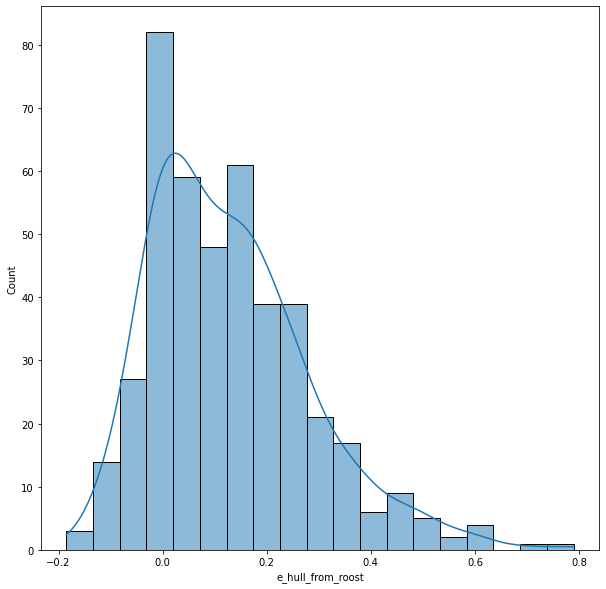

In [27]:
plt.figure(figsize=(10,10))
sns.histplot(data=merged_df, x="e_hull_from_roost", kde=True)